In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models,  regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc


In [2]:
df = pd.read_csv('/content/spacex_clean_data_before_encoding.csv')
display(df.head())
print(df.shape)

,success,flight_number,auto_update,upcoming,rocket_name,rocket_height,rocket_diameter,rocket_mass,rocket_boosters,rocket_cost_per_launch,...,is_night_launch,temperature,humidity,wind_speed,precipitation,cloud_cover,pressure,year,month,day
0,0,1,1,0,Falcon 1,22.25,1.68,30146,0,6700000,...,1,27.1,78.790,25.9,0.0,100.0,1009.5,2006,3,24
1,0,2,1,0,Falcon 1,22.25,1.68,30146,0,6700000,...,1,26.3,87.730,16.6,1.0,90.0,1011.5,2007,3,21
2,0,3,1,0,Falcon 1,22.25,1.68,30146,0,6700000,...,1,27.7,87.320,13.0,0.0,90.0,1010.6,2008,8,3
3,1,4,1,0,Falcon 1,22.25,1.68,30146,0,6700000,...,1,27.6,86.790,14.8,0.0,100.0,1011.9,2008,9,28
4,1,5,1,0,Falcon 1,22.25,1.68,30146,0,6700000,...,1,21.5,86.655,16.6,0.0,18.8,1009.9,2009,7,13


(205, 46)


In [3]:
df.columns

Index(['success', 'flight_number', 'auto_update', 'upcoming', 'rocket_name',
       'rocket_height', 'rocket_diameter', 'rocket_mass', 'rocket_boosters',
       'rocket_cost_per_launch', 'rocket_active', 'rocket_reusable',
       'rocket_engines', 'rocket_thrust_sea_level', 'rocket_thrust_vacuum',
       'launchpad_name', 'launchpad_region', 'launchpad_latitude',
       'launchpad_longitude', 'launch_attempts', 'launchpad_status',
       'payload_count', 'total_payload_mass', 'primary_payload_mass',
       'payload_orbit', 'payload_customer_type', 'payload_nationality',
       'payload_manufacturer', 'payload_type', 'launch_year', 'launch_month',
       'launch_day_of_year', 'launch_hour', 'launch_day_of_week',
       'launch_quarter', 'is_weekend', 'is_night_launch', 'temperature',
       'humidity', 'wind_speed', 'precipitation', 'cloud_cover', 'pressure',
       'year', 'month', 'day'],
      dtype='object')

In [4]:
# finding Correlations
correlation_matrix = df.corr(numeric_only=True)

target_collerations = correlation_matrix['success'].sort_values(key=abs, ascending=False)

print(target_collerations.drop("success"))



upcoming                  -0.852019
month                     -0.337915
launch_month              -0.337915
launch_quarter            -0.335970
flight_number             -0.326574
launch_day_of_year        -0.322537
launch_hour                0.297022
total_payload_mass         0.272968
primary_payload_mass       0.269538
is_night_launch           -0.266387
rocket_reusable            0.237498
rocket_active              0.237498
rocket_height              0.237498
launchpad_longitude       -0.225688
day                        0.220138
launchpad_latitude         0.200834
payload_count              0.177208
wind_speed                -0.147414
rocket_boosters           -0.139140
cloud_cover               -0.137277
temperature               -0.129415
precipitation             -0.102203
pressure                   0.087099
rocket_diameter           -0.080010
rocket_cost_per_launch     0.079058
is_weekend                 0.069166
launch_day_of_week         0.061472
year                      -0

In [5]:
# Selected Features
features = ['flight_number', 'launch_hour', 'primary_payload_mass',
            'rocket_reusable', 'launchpad_latitude', 'launchpad_longitude',
            'temperature', 'wind_speed', 'cloud_cover',
            'is_night_launch']  # newly added

# Numeric features for scaling
numeric_features = ['flight_number', 'launch_hour', 'primary_payload_mass',
                    'launchpad_latitude', 'launchpad_longitude',
                    'temperature', 'wind_speed', 'cloud_cover']
# Note: is_night_launch and rocket_reusable are passthrough (binary)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ], remainder='passthrough'  # rocket_reusable and is_night_launch pass through
)

# Feature names for visualization
feature_names = ['flight_number', 'launch_hour', 'primary_payload_mass',
                 'launchpad_latitude', 'launchpad_longitude',
                 'temperature', 'wind_speed', 'cloud_cover',
                 'rocket_reusable', 'is_night_launch']  # updated order

# Transform and split
X = df[features]
y = df['success']

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
print(np.isnan(X_train).sum())

0


In [7]:
# Convert training set to DataFrame for resampling
X_train_df = pd.DataFrame(X_train)
X_train_df['label'] = y_train.values

# Separate classes
df_majority = X_train_df[X_train_df['label'] == 1]
df_minority = X_train_df[X_train_df['label'] == 0]

# Undersample majority (e.g., 2x minority size)
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 2,  # adjust multiplier as needed
    random_state=42
)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features/labels again
X_train_balanced = df_balanced.drop(columns='label').values
y_train_balanced = df_balanced['label'].values

In [8]:
df_balanced['label'].value_counts()

,count
label,
1,38
0,19


In [9]:
# Convert to DataFrame for convenience
X_train_df = pd.DataFrame(X_train, columns=feature_names[:-2] + ['rocket_reusable', 'is_night_launch'])
y_train_df = pd.Series(y_train, name='label')

# Combine
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Drop rows where 'label' is NaN
train_df = train_df.dropna(subset=['label'])

# Separate features and label after dropping NaNs
X_train_clean = train_df.drop(columns='label').values
y_train_clean = train_df['label'].values

# Impute missing values in features only (not labels)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean)

# Now apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_imputed, y_train_clean)


In [10]:
# Heavier weight on class 0 (failures)
class_weight_dict = {0: 6.0, 1: 1.0}


In [11]:
input_shape = X_train_balanced.shape[1]

model = models.Sequential([
    layers.InputLayer(input_shape=(input_shape,)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)


In [13]:
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weight_dict,
    verbose=2
)


Epoch 1/100


3/3 - 6s - 2s/step - accuracy: 0.8889 - loss: 1.2076 - val_accuracy: 0.0000e+00 - val_loss: 1.9941
Epoch 2/100


3/3 - 0s - 112ms/step - accuracy: 0.8000 - loss: 1.6489 - val_accuracy: 0.0000e+00 - val_loss: 1.9465
Epoch 3/100


3/3 - 0s - 43ms/step - accuracy: 0.8000 - loss: 1.2546 - val_accuracy: 0.0000e+00 - val_loss: 1.8904
Epoch 4/100


3/3 - 0s - 33ms/step - accuracy: 0.7333 - loss: 1.2987 - val_accuracy: 0.0000e+00 - val_loss: 1.8327
Epoch 5/100


3/3 - 0s - 45ms/step - accuracy: 0.8222 - loss: 1.2832 - val_accuracy: 0.0833 - val_loss: 1.7673
Epoch 6/100


3/3 - 0s - 63ms/step - accuracy: 0.8222 - loss: 1.2700 - val_accuracy: 0.2500 - val_loss: 1.7197
Epoch 7/100


3/3 - 0s - 33ms/step - accuracy: 0.7778 - loss: 1.2339 - val_accuracy: 0.5833 - val_loss: 1.6692
Epoch 8/100


3/3 - 0s - 33ms/step - accuracy: 0.8889 - loss: 1.1243 - val_accuracy: 0.5833 - val_loss: 1.6178
Epoch 9/100


3/3 - 0s - 46ms/step - accuracy: 0.8667 - loss: 1.0106 - val_accuracy: 0.5833 - val_loss: 1.5797
Epoch 10/100


3/3 - 0s - 32ms/step - accuracy: 0.8444 - loss: 1.1298 - val_accuracy: 0.6667 - val_loss: 1.5499
Epoch 11/100


3/3 - 0s - 33ms/step - accuracy: 0.7333 - loss: 1.1279 - val_accuracy: 0.6667 - val_loss: 1.5281
Epoch 12/100


3/3 - 0s - 34ms/step - accuracy: 0.8222 - loss: 1.0571 - val_accuracy: 0.6667 - val_loss: 1.5044
Epoch 13/100


3/3 - 0s - 33ms/step - accuracy: 0.8444 - loss: 0.9437 - val_accuracy: 0.6667 - val_loss: 1.4890
Epoch 14/100


3/3 - 0s - 32ms/step - accuracy: 0.8222 - loss: 0.9804 - val_accuracy: 0.6667 - val_loss: 1.4750
Epoch 15/100


3/3 - 0s - 39ms/step - accuracy: 0.8222 - loss: 0.9453 - val_accuracy: 0.6667 - val_loss: 1.4639
Epoch 16/100


3/3 - 0s - 40ms/step - accuracy: 0.8889 - loss: 0.8162 - val_accuracy: 0.6667 - val_loss: 1.4606
Epoch 17/100
3/3 - 0s - 26ms/step - accuracy: 0.8222 - loss: 0.9373 - val_accuracy: 0.6667 - val_loss: 1.4688
Epoch 18/100
3/3 - 0s - 27ms/step - accuracy: 0.8222 - loss: 0.9460 - val_accuracy: 0.6667 - val_loss: 1.4700
Epoch 19/100
3/3 - 0s - 47ms/step - accuracy: 0.8222 - loss: 0.9008 - val_accuracy: 0.6667 - val_loss: 1.4739
Epoch 20/100
3/3 - 0s - 25ms/step - accuracy: 0.8222 - loss: 0.8823 - val_accuracy: 0.6667 - val_loss: 1.4809
Epoch 21/100
3/3 - 0s - 47ms/step - accuracy: 0.8667 - loss: 0.7478 - val_accuracy: 0.6667 - val_loss: 1.4970
Epoch 22/100
3/3 - 0s - 47ms/step - accuracy: 0.8667 - loss: 0.8349 - val_accuracy: 0.6667 - val_loss: 1.5077
Epoch 23/100
3/3 - 0s - 25ms/step - accuracy: 0.8889 - loss: 0.7667 - val_accuracy: 0.6667 - val_loss: 1.5194
Epoch 24/100
3/3 - 0s - 26ms/step - accuracy: 0.8667 - loss: 0.7945 - val_accuracy: 0.6667 - val_loss: 1.5252
Epoch 25/100
3/3 - 0s -

In [19]:
y_test_pred_prob = model.predict(X_test)
threshold = 0.348
y_test_pred = (y_test_pred_prob > threshold).astype(int).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {auc:.4f}")


Confusion Matrix:
[[ 2  3]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.92      0.94      0.93        36

    accuracy                           0.88        41
   macro avg       0.71      0.67      0.69        41
weighted avg       0.87      0.88      0.87        41

Test Accuracy: 0.8780
ROC AUC Score: 0.8333


In [35]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = model.predict(X_test).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Find threshold maximizing F1 for class 0
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold:.3f}, F1 score: {f1_scores[best_idx]:.3f}")

# Predict with best threshold
y_pred_best = (y_pred_prob > best_threshold).astype(int)

# Evaluate again with best threshold
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Best threshold for F1: 0.340, F1 score: 0.960
[[ 2  3]
 [ 1 35]]
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.92      0.97      0.95        36

    accuracy                           0.90        41
   macro avg       0.79      0.69      0.72        41
weighted avg       0.89      0.90      0.89        41



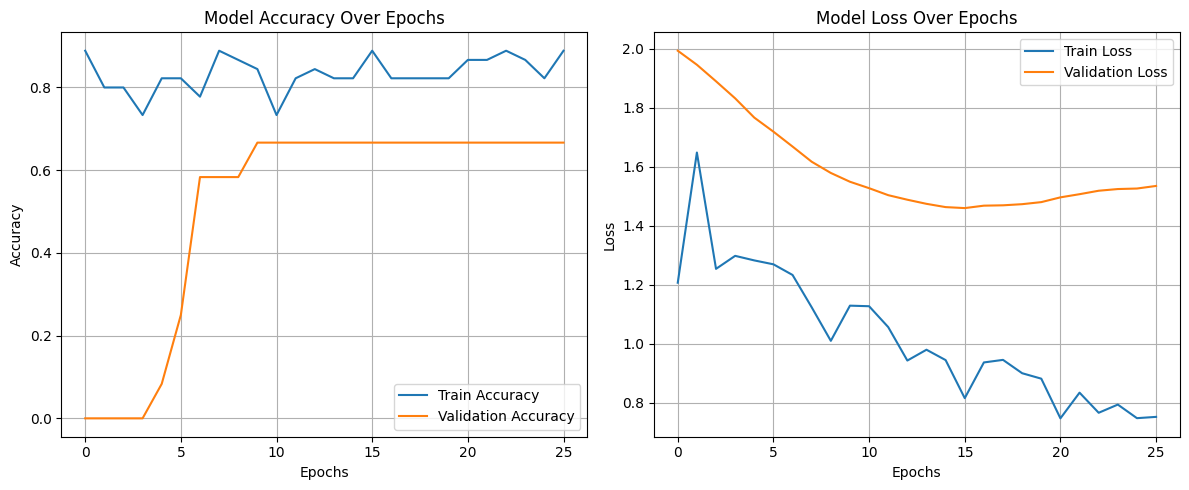

In [22]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('model_performance.png')
plt.tight_layout()
plt.show()


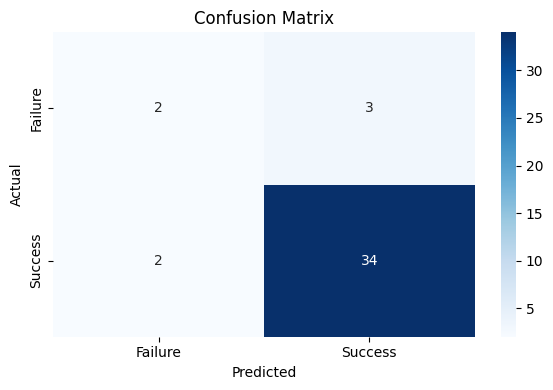

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Failure", "Success"], yticklabels=["Failure", "Success"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


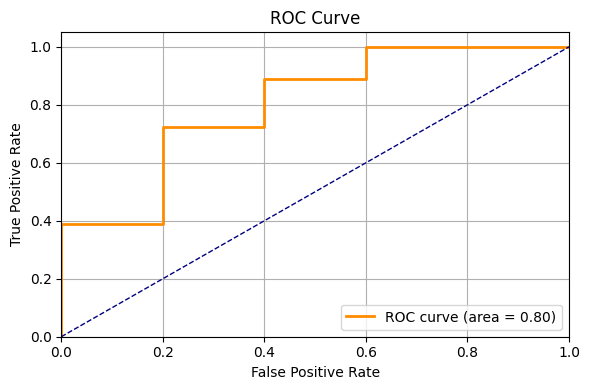

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-24-b18f9e400dda>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


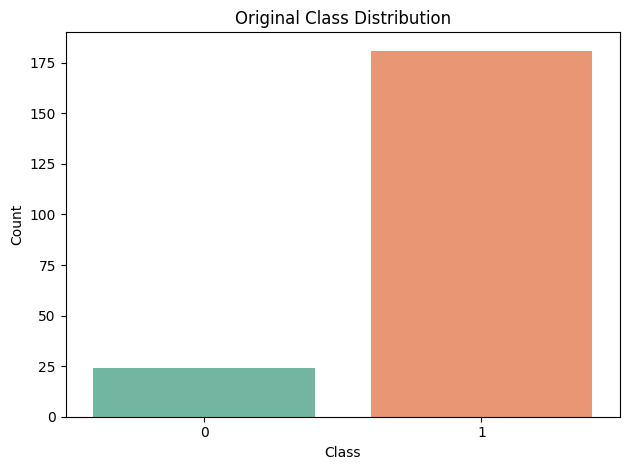

<ipython-input-24-b18f9e400dda>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette="Set1")


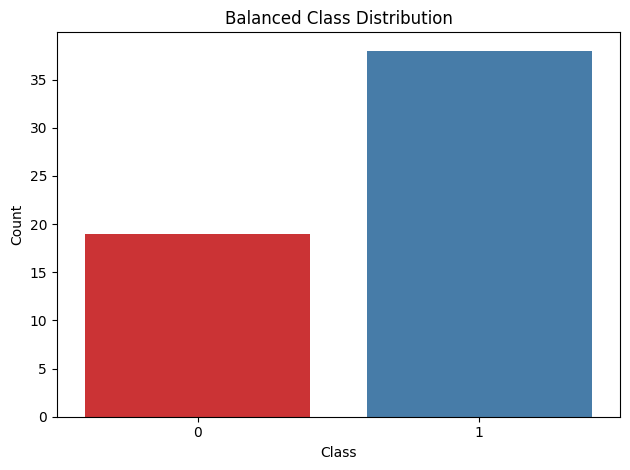

In [24]:
# Before
sns.countplot(x=y, palette="Set2")
plt.title("Original Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# After balancing (y_train_balanced assumed)
sns.countplot(x=y_train_balanced, palette="Set1")
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [25]:
model.save('final_model.keras')


In [26]:
import joblib

# Save preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')
print("Preprocessor saved successfully.")


Preprocessor saved successfully.


In [29]:
from tensorflow.keras.models import load_model

# Load the entire model from .h5 file
loaded_model = load_model('final_model.keras')

# Predict with loaded model on test set (same preprocessing applied!)
y_test_pred_prob = loaded_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.317).astype(int).flatten()

# Evaluate loaded model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {auc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Confusion Matrix:
[[ 2  3]
 [ 0 36]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.92      1.00      0.96        36

    accuracy                           0.93        41
   macro avg       0.96      0.70      0.77        41
weighted avg       0.93      0.93      0.91        41

Test Accuracy: 0.9268
ROC AUC Score: 0.8333


In [30]:
import pandas as pd
import numpy as np

# Set your trained threshold
THRESHOLD = 0.34

def predict_launch_success(input_data, preprocessor, model, threshold=THRESHOLD):
    """
    Predict launch success (0 or 1) based on input features.

    Parameters:
        input_data (dict): Input with feature keys matching training.
        preprocessor (ColumnTransformer): Fitted preprocessor used during training.
        model (tf.keras.Model): Trained Keras model.
        threshold (float): Classification threshold.

    Returns:
        dict: {
            'probability': float,
            'prediction': int
        }
    """
    # Convert input dict to DataFrame with one row
    input_df = pd.DataFrame([input_data])  # <- fixed part

    # Apply preprocessing
    input_processed = preprocessor.transform(input_df)

    # Predict probability
    prob = model.predict(input_processed)[0][0]

    # Apply threshold
    pred_class = int(prob > threshold)

    return {
        'probability': round(prob, 4),
        'prediction': pred_class
    }


In [36]:
sample_input = {
    'flight_number': 1,
    'launch_hour': 17,
    'primary_payload_mass': 50000,
    'rocket_reusable': 1,
    'launchpad_latitude': 28.5623,
    'launchpad_longitude': -80.5774,
    'temperature': 26.0,
    'wind_speed': 80.0,
    'cloud_cover': 20,
    'is_night_launch': 1
}

result = predict_launch_success(sample_input, preprocessor, model,threshold=0.340)
print(f"Prediction: {'Success' if result['prediction'] == 1 else 'Failure'}")
print(f"Probability: {result['probability']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: Success
Probability: 0.9991999864578247


In [44]:
# Test cases likely to fail (bad conditions: early flights, night, cold, high wind)
failure_inputs = [
    {
        'flight_number': 5,
        'launch_hour': 2,
        'primary_payload_mass': 300,
        'rocket_reusable': 0,
        'launchpad_latitude': 28.5,
        'launchpad_longitude': -80.6,
        'temperature': 0.0,
        'wind_speed': 40.0,
        'cloud_cover': 90,
        'is_night_launch': 1
    },
    {
        'flight_number': 10,
        'launch_hour': 3,
        'primary_payload_mass': 200,
        'rocket_reusable': 0,
        'launchpad_latitude': 34.6,
        'launchpad_longitude': -120.6,
        'temperature': -2.0,
        'wind_speed': 30.0,
        'cloud_cover': 100,
        'is_night_launch': 1
    },
    {
        'flight_number': 15,
        'launch_hour': 0,
        'primary_payload_mass': 350,
        'rocket_reusable': 0,
        'launchpad_latitude': 28.6,
        'launchpad_longitude': -80.6,
        'temperature': 5.0,
        'wind_speed': 35.0,
        'cloud_cover': 85,
        'is_night_launch': 1
    }
]
# Loop through and print results
for i, test_input in enumerate(failure_inputs, 1):
    result = predict_launch_success(test_input, preprocessor, model,threshold=0.340)
    print(f"\nFailure Test Case #{i}")
    print(f"Prediction: {'Success' if result['prediction'] == 1 else 'Failure'}")
    print(f"Probability: {result['probability']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Failure Test Case #1
Prediction: Success
Probability: 0.8514999747276306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Failure Test Case #2
Prediction: Success
Probability: 0.8215000033378601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Failure Test Case #3
Prediction: Success
Probability: 0.7890999913215637


In [ ]:
thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25]
for threshold in thresholds:
    print(f"\nTesting with Threshold = {threshold}")
    for i, test_input in enumerate(failure_inputs, 1):
        result = predict_launch_success(test_input, preprocessor, model, threshold=threshold)
        print(f"  Case {i}: Prediction = {'Success' if result['prediction'] == 1 else 'Failure'}, Prob = {result['probability']}")



Testing with Threshold = 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
  Case 1: Prediction = Failure, Prob = 0.4221999943256378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
  Case 2: Prediction = Failure, Prob = 0.4438000023365021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
  Case 3: Prediction = Failure, Prob = 0.4083000123500824

Testing with Threshold = 0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  Case 1: Prediction = Failure, Prob = 0.4221999943256378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
  Case 2: Prediction = Failure, Prob = 0.4438000023365021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
  Case 3: Prediction = Failure, Prob = 0.4083000123500824

Testing with Threshold = 0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
  Case 1: Prediction = Success, Prob = 0.4221999943256378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
  Case 2: Prediction = Success, Prob = 0.4438000023365021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
  Case 3: Prediction = Success, Prob = 0.4083000123500824

Testing with Threshold = 0.35
1/1 ━━━━━━━━━━

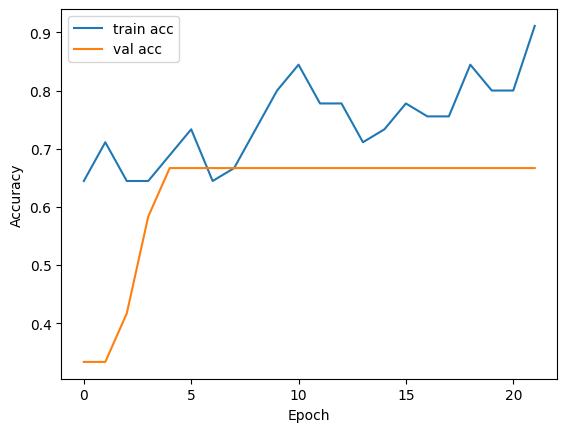

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Training Loss Curves

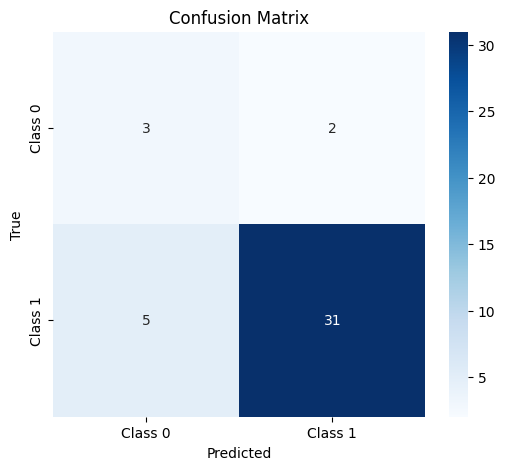

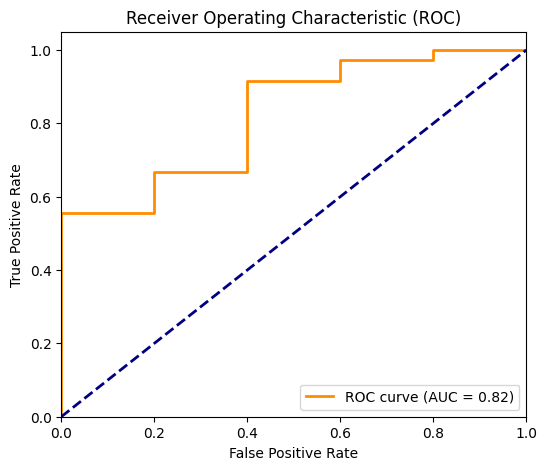

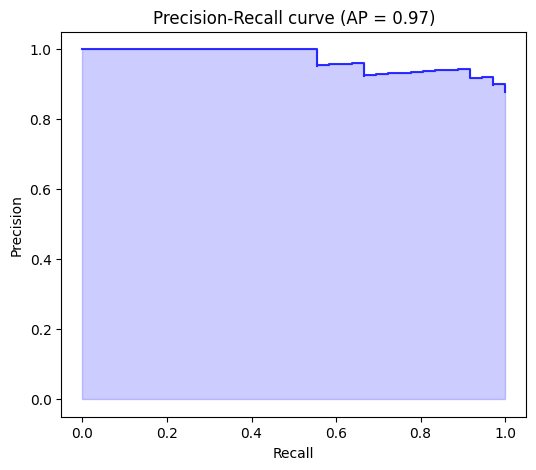


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.94      0.86      0.90        36

    accuracy                           0.83        41
   macro avg       0.66      0.73      0.68        41
weighted avg       0.87      0.83      0.85        41

Precision: 0.9394
Recall:    0.8611
F1 Score:  0.8986


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, precision_score, recall_score, f1_score

# Assuming best_model, X_test, y_test, and y_pred_prob, y_pred are already defined as in your previous code

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 3. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.step(recall_vals, precision_vals, color='b', alpha=0.8, where='post')
plt.fill_between(recall_vals, precision_vals, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.show()

# 4. (Optional) Training history plot function if you have `history` object

def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    # Accuracy plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Accuracy over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss plot
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Loss over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Uncomment below to plot if you have your training history
# plot_training_history(history)

# 5. Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Print metrics summary
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [ ]:

def visualize_model_performance(model, history, X_test, y_test, y_pred_prob, threshold=0.3, feature_names=None, save_plots=False):
    """
    Visualize comprehensive model performance and training results.

    Args:
        model: Trained keras model.
        history: Keras History object from training.
        X_test: Test features (numpy array).
        y_test: True test labels.
        y_pred_prob: Predicted probabilities from model on X_test.
        threshold: Threshold to convert predicted probabilities to class labels.
        feature_names: List of feature names (optional, for feature importance).
        save_plots: Boolean, whether to save plots as PNG file.

    """
    print("Generating model performance visualizations...")

    # Calculate predicted classes using threshold
    y_pred = (y_pred_prob > threshold).astype(int).flatten()

    # Compute metrics
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve and average precision
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)

    # Setup plot style and figure size
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(30, 22))

    # 1. Training Loss
    ax1 = plt.subplot(3, 4, 1)
    ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. Training Accuracy
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Confusion Matrix
    ax3 = plt.subplot(3, 4, 3)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Failure', 'Success'],
                yticklabels=['Failure', 'Success'],
                ax=ax3)
    ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Predicted Label')
    ax3.set_ylabel('True Label')

    # 4. ROC Curve
    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(fpr, tpr, color='purple', lw=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax4.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Prediction Probability Distribution
    ax5 = plt.subplot(3, 4, 5)
    ax5.hist(y_pred_prob[y_test == 0].flatten(), bins=20, alpha=0.7, label='Actual Failures', color='red', density=True)
    ax5.hist(y_pred_prob[y_test == 1].flatten(), bins=20, alpha=0.7, label='Actual Successes', color='green', density=True)
    ax5.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.legend()
    ax5.grid(alpha=0.3)

    # 6. Neural Network Architecture (Layer units)
    ax6 = plt.subplot(3, 4, 6)
    layer_info = [(f'Layer {i+1}', layer.units) for i, layer in enumerate(model.layers) if hasattr(layer, 'units')]
    if layer_info:
        names, units = zip(*layer_info)
        y_pos = np.arange(len(units))
        ax6.barh(y_pos, units, color='skyblue', edgecolor='navy')
        ax6.set_yticks(y_pos)
        ax6.set_yticklabels(names)
        ax6.set_xlabel('Number of Neurons')
        ax6.set_title('Neural Network Architecture', fontsize=14, fontweight='bold')
        for i, val in enumerate(units):
            ax6.text(val + max(units)*0.01, i, str(val), va='center', fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'No layer unit info available', ha='center', va='center')
        ax6.set_title('Neural Network Architecture', fontsize=14, fontweight='bold')

    # 7. Classification Metrics Bar Plot
    ax7 = plt.subplot(3, 4, 7)
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['0', '1']  # failure=0, success=1

    metric_vals = []
    for cls in classes:
        if cls in report:
            metric_vals.append([report[cls][m] for m in metrics])
        else:
            metric_vals.append([0,0,0])

    x = np.arange(len(metrics))
    width = 0.35
    ax7.bar(x - width/2, metric_vals[0], width, label='Failure', color='red', alpha=0.7)
    ax7.bar(x + width/2, metric_vals[1], width, label='Success', color='green', alpha=0.7)
    ax7.set_xticks(x)
    ax7.set_xticklabels(metrics)
    ax7.set_ylabel('Score')
    ax7.set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(alpha=0.3)

    # 8. Feature Importance (First Layer Weights Approximation)
    ax8 = plt.subplot(3, 4, 8)
    if feature_names is not None and len(feature_names) <= 15:
        try:
            weights = model.layers[0].get_weights()[0]  # shape: (num_features, units)
            importance = np.mean(np.abs(weights), axis=1)
            indices = np.argsort(importance)[-10:]  # top 10
            top_feats = [feature_names[i] for i in indices]
            top_imp = importance[indices]

            ax8.barh(range(len(top_feats)), top_imp, color='orange')
            ax8.set_yticks(range(len(top_feats)))
            ax8.set_yticklabels(top_feats)
            ax8.set_xlabel('Average Absolute Weight')
            ax8.set_title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
        except Exception:
            ax8.text(0.5, 0.5, 'Feature importance calculation error',
                     ha='center', va='center', fontsize=12)
            ax8.set_title('Feature Importance', fontsize=14, fontweight='bold')
    else:
        ax8.text(0.5, 0.5, f'Too many features ({len(feature_names) if feature_names else "N/A"}) to display',
                 ha='center', va='center', fontsize=12)
        ax8.set_title('Feature Importance', fontsize=14, fontweight='bold')

    # 9. Precision & Recall Over Epochs (if available)
    ax9 = plt.subplot(3, 4, 9)
    if all(k in history.history for k in ['precision', 'val_precision', 'recall', 'val_recall']):
        epochs = range(1, len(history.history['precision']) + 1)
        ax9.plot(epochs, history.history['precision'], label='Training Precision', linewidth=2)
        ax9.plot(epochs, history.history['val_precision'], label='Validation Precision', linewidth=2)
        ax9.plot(epochs, history.history['recall'], label='Training Recall', linewidth=2)
        ax9.plot(epochs, history.history['val_recall'], label='Validation Recall', linewidth=2)
        ax9.set_title('Precision & Recall Over Epochs', fontsize=14, fontweight='bold')
        ax9.set_xlabel('Epoch')
        ax9.set_ylabel('Score')
        ax9.legend()
        ax9.grid(alpha=0.3)
    else:
        ax9.text(0.5, 0.5, 'Precision/Recall history not available', ha='center', va='center')
        ax9.set_title('Precision & Recall Over Epochs', fontsize=14, fontweight='bold')

    # 10. Loss Distribution Last 10 Epochs
    ax10 = plt.subplot(3, 4, 10)
    last_train_loss = history.history['loss'][-10:]
    last_val_loss = history.history['val_loss'][-10:]
    ax10.boxplot([last_train_loss, last_val_loss], tick_labels=['Train Loss', 'Val Loss'])
    ax10.set_title('Loss Distribution (Last 10 Epochs)', fontsize=14, fontweight='bold')
    ax10.set_ylabel('Loss')
    ax10.grid(alpha=0.3)

    # 11. Prediction Probability Ranges by Class
    ax11 = plt.subplot(3, 4, 11)
    ax11.boxplot([y_pred_prob[y_test==0].flatten(), y_pred_prob[y_test==1].flatten()],
             tick_labels=['Actual Failures', 'Actual Successes'])
    ax11.set_title('Prediction Probability Ranges', fontsize=14, fontweight='bold')
    ax11.set_ylabel('Predicted Probability')
    ax11.grid(alpha=0.3)

    # 12. Model Summary Text
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    summary_lines = [
        "MODEL PERFORMANCE SUMMARY",
        "=========================",
        f"Test Accuracy: {test_accuracy:.4f}",
        f"Test Precision: {precision:.4f}",
        f"Test Recall: {recall:.4f}",
        f"Test F1-score: {f1:.4f}",
        f"AUC Score: {roc_auc:.4f}",
        "",
        f"Total Parameters: {model.count_params():,}",
        f"Training Epochs: {len(history.history['loss'])}",
        f"Features Used: {len(feature_names) if feature_names else 'N/A'}",
        "",
        "SUCCESS RATE ANALYSIS:",
        f"Predicted Successes: {np.sum(y_pred)}/{len(y_pred)}",
        f"Actual Successes: {np.sum(y_test)}/{len(y_test)}"
    ]
    ax12.text(0.05, 0.95, '\n'.join(summary_lines),
              transform=ax12.transAxes,
              fontsize=11,
              verticalalignment='top',
              fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    plt.tight_layout(pad=3.5)

    if save_plots:
        plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
        print("Plots saved as 'model_performance_analysis.png'")

    plt.show()

    # Print classification report
    print("\n" + "="*50)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))


Generating model performance visualizations...
Plots saved as 'model_performance_analysis.png'


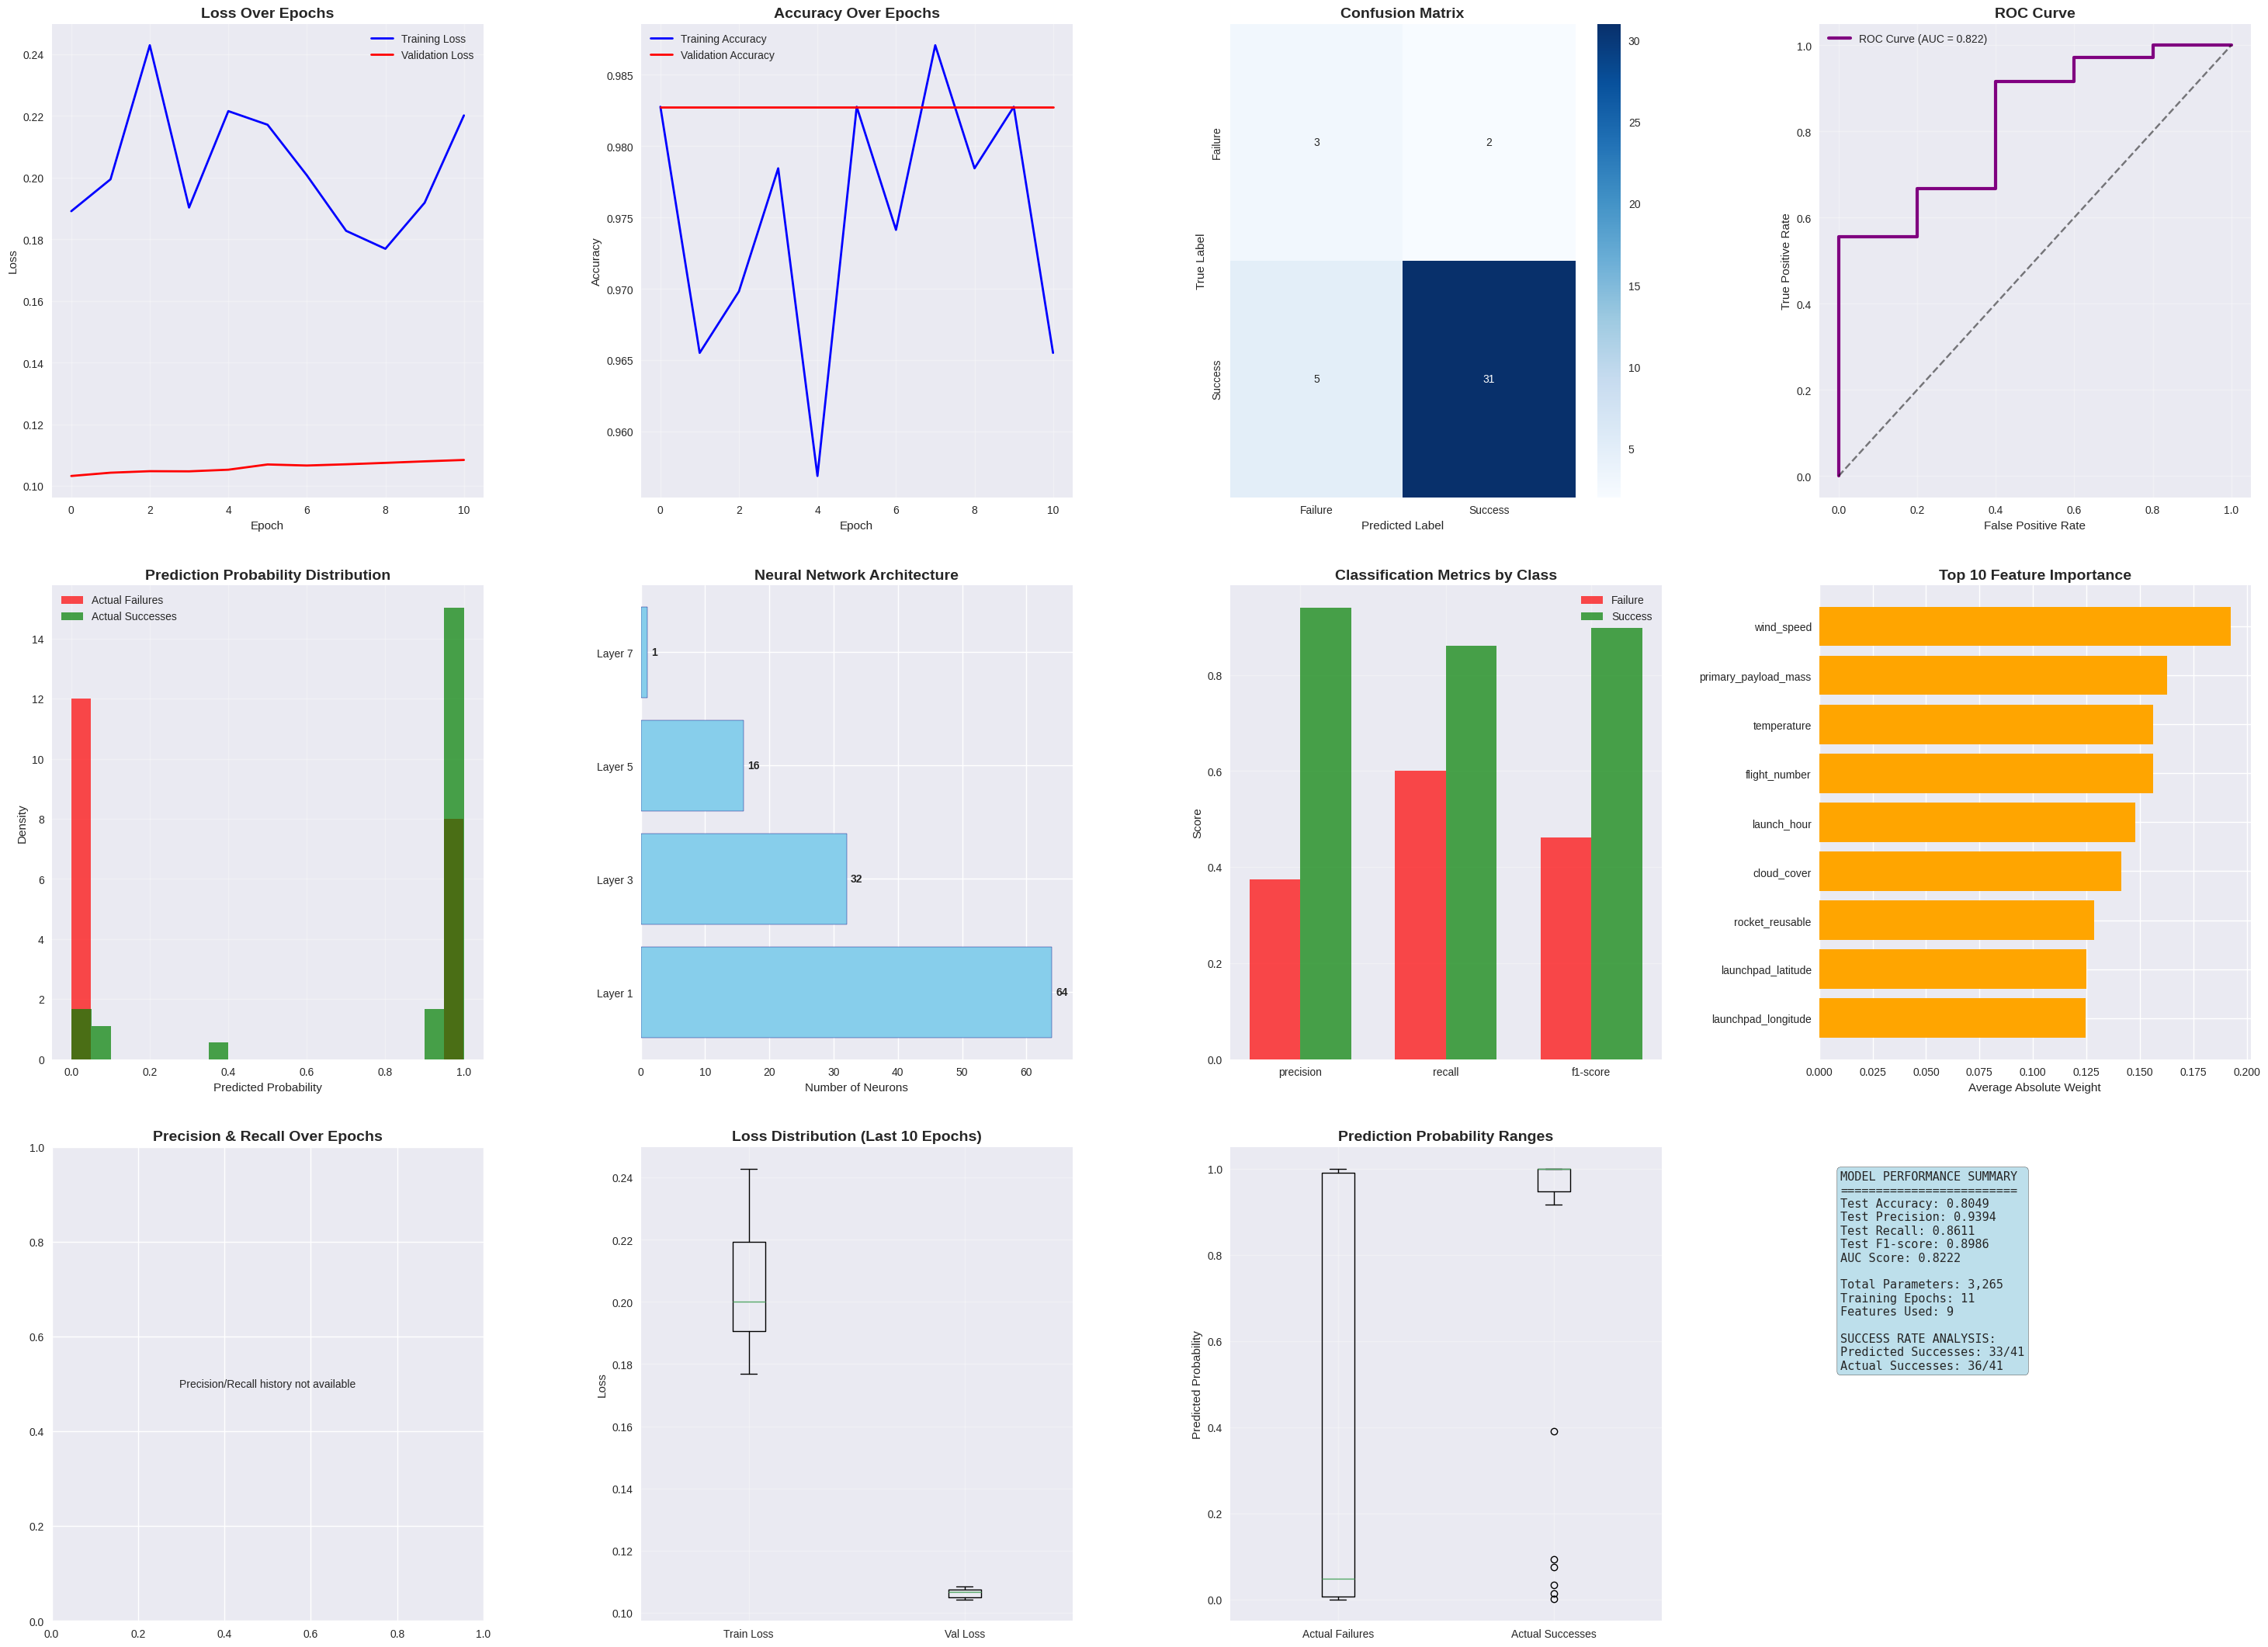


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Failure       0.38      0.60      0.46         5
     Success       0.94      0.86      0.90        36

    accuracy                           0.83        41
   macro avg       0.66      0.73      0.68        41
weighted avg       0.87      0.83      0.85        41



In [ ]:
visualize_model_performance(
    model=model,
    history=history,
    X_test=X_test,
    y_test=y_test,
    y_pred_prob=y_pred_prob,
    feature_names=feature_names,
    save_plots=True,
    threshold=0.20
)


# Testing

In [ ]:
# Testing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,  # or use validation_data=(X_val, y_val)
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)



Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9718 - loss: 0.1322 - val_accuracy: 0.9697 - val_loss: 0.1688
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9746 - loss: 0.2017 - val_accuracy: 0.9697 - val_loss: 0.1694
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9637 - loss: 0.1862 - val_accuracy: 0.9697 - val_loss: 0.1698
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9459 - loss: 0.2338 - val_accuracy: 0.9697 - val_loss: 0.1696
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9607 - loss: 0.1461 - val_accuracy: 0.9697 - val_loss: 0.1692
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9493 - loss: 0.1756 - val_accuracy: 0.9697 - val_loss: 0.1689
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9553 - loss: 0.1520 - val_accuracy: 0.9697 - val_loss: 0.1685
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9404 - loss: 0.1682 - val_accuracy: 0.9697 - val_loss: 0.1679


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8341 - loss: 0.7681
Test Accuracy: 0.8293, Test Loss: 0.7980


In [ ]:
from keras.models import load_model

# Load the best model (saved when val_loss was lowest)
best_model = load_model('/content/best_spacex_model.h5')

# Re-evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy (best model): {test_acc:.4f}, Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8341 - loss: 0.7784 
Test Accuracy (best model): 0.8293, Test Loss: 0.7973


In [ ]:
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 3  2]
 [ 5 31]]
              precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.94      0.86      0.90        36

    accuracy                           0.83        41
   macro avg       0.66      0.73      0.68        41
weighted avg       0.87      0.83      0.85        41



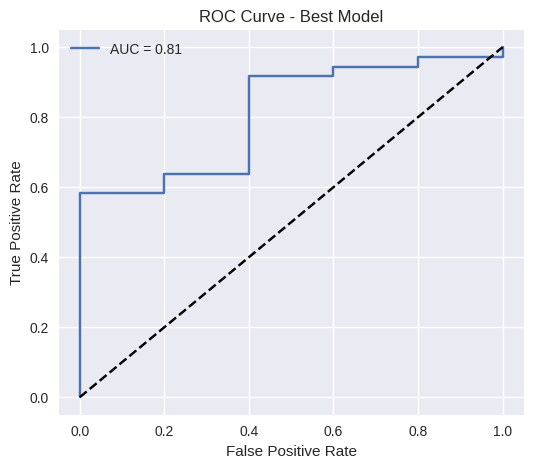

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend()
plt.grid(True)
plt.show()
